In [71]:
import pandas as pd
import random
import os
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn")
colors = sns.color_palette("muted", 10)
sns.set(font='NanumBarunGothic', font_scale=1.5)

import missingno as msno
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

In [72]:
train_dup_columns = train_df.columns[train_df.T.duplicated()].to_list()
test_dup_columns = test_df.columns[test_df.T.duplicated()].to_list()
oc = []
for c in train_dup_columns:
    if c not in test_dup_columns:
        oc.append(c)
print(len(oc))

65


In [73]:
T = []
TT = []
for col in train_df:
    if train_df[col].nunique() < 2:
        T.append(col)
for col in test_df:
    if test_df[col].nunique() < 2:
        TT.append(col)

In [74]:
final = []
for col in TT:
    if col not in T:
        final.append(col)

In [76]:
corr = pd.read_csv("correlation/correlation.csv")
cor = []
for i in range(len(corr)):
    if corr.iloc[i]['feature'] in final:
        cor.append(corr.iloc[i]['correlation'])
print(len(cor))

561


In [77]:
nan_column = []
for col in train_df:
    if train_df[col].isna().sum() / len(train_df) > 0.8:
        nan_column.append(col)
print(len(nan_column))

692


In [47]:
# 바 위에 text표시하기
def bar_text(ax, y=True):
    if y:
        for p in ax.patches:
            #height = p.get_height()
            width = p.get_width()
            ax.text(width + 3, p.get_y() + p.get_height() / 2., width, ha = 'center', size=12)
            #ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
    else:
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 2, height, ha = 'center', size = 12)

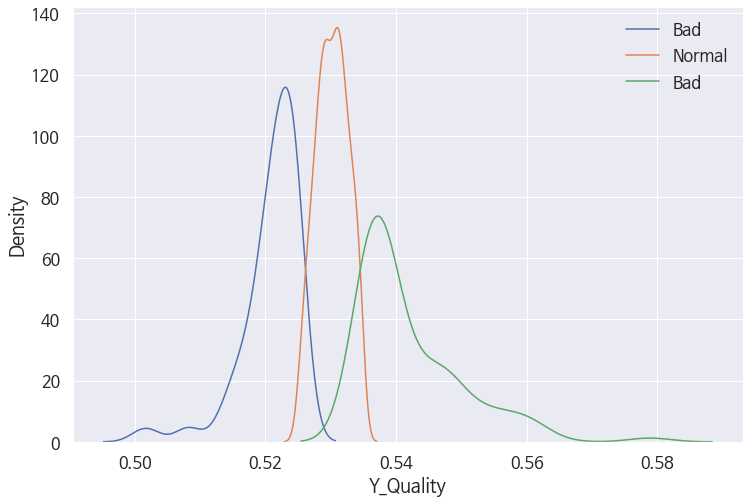

In [2]:
f, ax = plt.subplots(1, 1, figsize=(12,8))
sns.kdeplot(train_df[train_df["Y_Class"] == 0]["Y_Quality"], ax=ax)
sns.kdeplot(train_df[train_df["Y_Class"] == 1]["Y_Quality"], ax=ax)
sns.kdeplot(train_df[train_df["Y_Class"] == 2]["Y_Quality"], ax=ax)
plt.legend(["Bad", "Normal", "Bad"])

In [3]:
print(train_df[train_df["Y_Class"] == 1]["Y_Quality"].min())
print(train_df[train_df["Y_Class"] == 1]["Y_Quality"].max())


0.525085714
0.534842857


In [4]:
# 기준치 이하의 Under class 개수
print((train_df[train_df["Y_Quality"] < 0.525085714]["Y_Class"] == 0).sum())

print((train_df[train_df["Y_Quality"] <= 0.534842857]["Y_Class"] == 1).sum())

# 기준치 이상의 Over class 개수
print((train_df[train_df["Y_Quality"] > 0.534842857]["Y_Class"] == 2).sum())

# 최소값 이하면서 normal인 것
print((train_df[train_df["Y_Quality"] < 0.525085714]["Y_Class"] == 1).sum())

print("Under", (train_df["Y_Class"] == 0).sum())
print("Normal", (train_df["Y_Class"] == 1).sum())
print("Over", (train_df["Y_Class"] == 2).sum())


88
407
103
0
Under 88
Normal 407
Over 103


#### 결론: 샘플들은 정해진 Y_Quality Threshold 에 의해 Y_Class가 나눠짐

In [2]:
for col in train_df:
    if train_df[col].nunique() < 2:
        train_df.drop(columns=col, inplace=True)
        test_df.drop(columns=col, inplace=True)

### 생산 LINE에 따른 BIAS 확인

In [42]:
under = train_df[train_df["Y_Class"] == 0]
normal = train_df[train_df["Y_Class"] == 1]
over = train_df[train_df["Y_Class"] == 2]

Text(0.5, 1.0, 'Over LINE distribution')

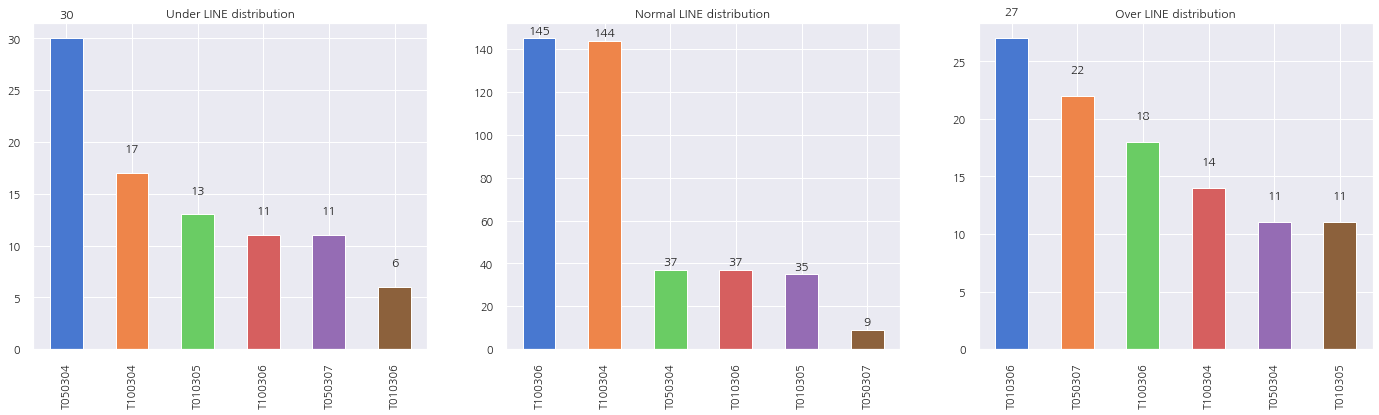

In [48]:
sns.set(font='NanumGothic', font_scale=1.0)
f, ax = plt.subplots(1, 3, figsize=(24,6))
bar_text(under['LINE'].value_counts().plot.bar(ax=ax[0], color=colors), y=False)
bar_text(normal['LINE'].value_counts().plot.bar(ax=ax[1], color=colors), y=False)
bar_text(over['LINE'].value_counts().plot.bar(ax=ax[2], color=colors),y=False)
ax[0].set_title("Under LINE distribution")
ax[1].set_title("Normal LINE distribution")
ax[2].set_title("Over LINE distribution")
# 라인에 따른 bias 존재
#          U   N   O
# T010305: 13, 35, 11
# T010306: 6,  37, 27
# T050304: 30, 37, 11
# T050307: 11, 9,  22
# T100304: 17, 144, 14
# T100306: 11, 145, 18

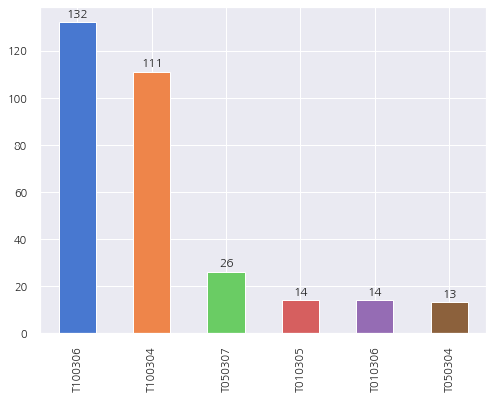

In [54]:
# Normal이 많았던 
sns.set(font='NanumGothic', font_scale=1.0)
f, ax = plt.subplots(1, 1, figsize=(8,6))
bar_text(test_df['LINE'].value_counts().plot.bar(ax=ax, color=colors), y=False)

### PRODUCT_CODE 에 따른 분포
-----
T_31은 보통품목이 많고, A_31 불량이 많음, O_는 거의 보이지 않음

Text(0.5, 1.0, 'Over PRODUCT_CODE distribution')

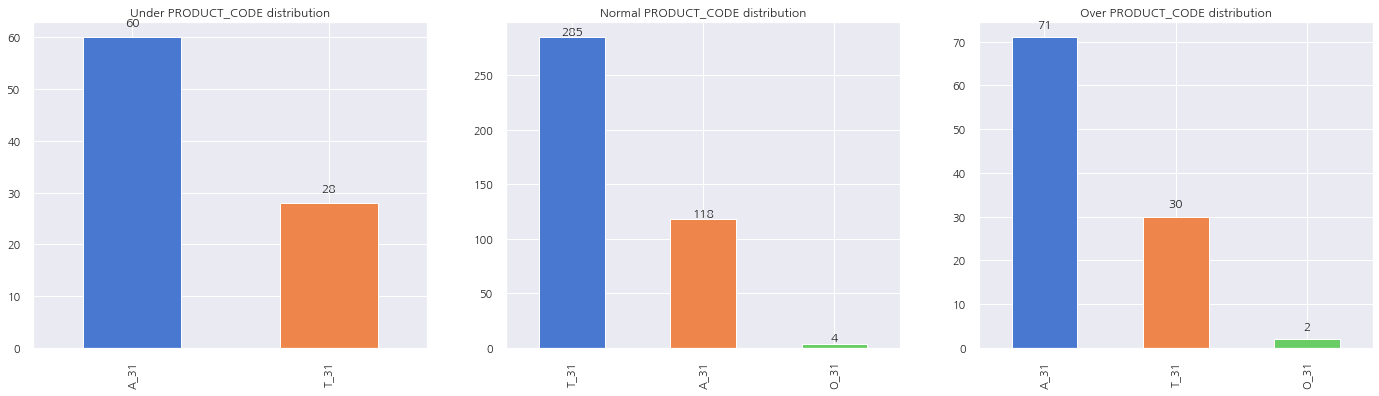

In [50]:
sns.set(font='NanumGothic', font_scale=1.0)
f, ax = plt.subplots(1, 3, figsize=(24,6))
bar_text(under['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[0], color=colors), y=False)
bar_text(normal['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[1], color=colors), y=False)
bar_text(over['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[2], color=colors),y=False)
ax[0].set_title("Under PRODUCT_CODE distribution")
ax[1].set_title("Normal PRODUCT_CODE distribution")
ax[2].set_title("Over PRODUCT_CODE distribution")

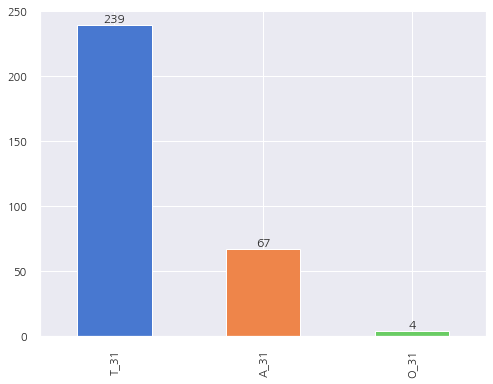

In [53]:
sns.set(font='NanumGothic', font_scale=1.0)
f, ax = plt.subplots(1, 1, figsize=(8,6))
bar_text(test_df['PRODUCT_CODE'].value_counts().plot.bar(ax=ax, color=colors), y=False)

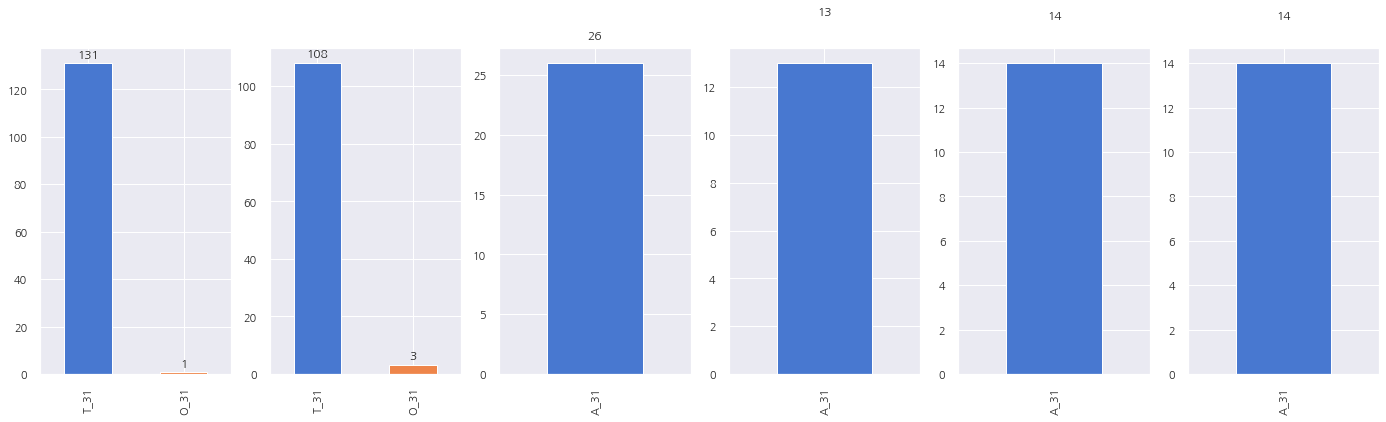

In [58]:
sns.set(font='NanumGothic', font_scale=1.0)
f, ax = plt.subplots(1, 6, figsize=(24,6))
bar_text(test_df[test_df['LINE'] == 'T100306']['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[0], color=colors), y=False)
bar_text(test_df[test_df['LINE'] == 'T100304']['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[1], color=colors), y=False)
bar_text(test_df[test_df['LINE'] == 'T050307']['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[2], color=colors), y=False)
bar_text(test_df[test_df['LINE'] == 'T050304']['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[3], color=colors), y=False)
bar_text(test_df[test_df['LINE'] == 'T010305']['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[4], color=colors), y=False)
bar_text(test_df[test_df['LINE'] == 'T010306']['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[5], color=colors), y=False)



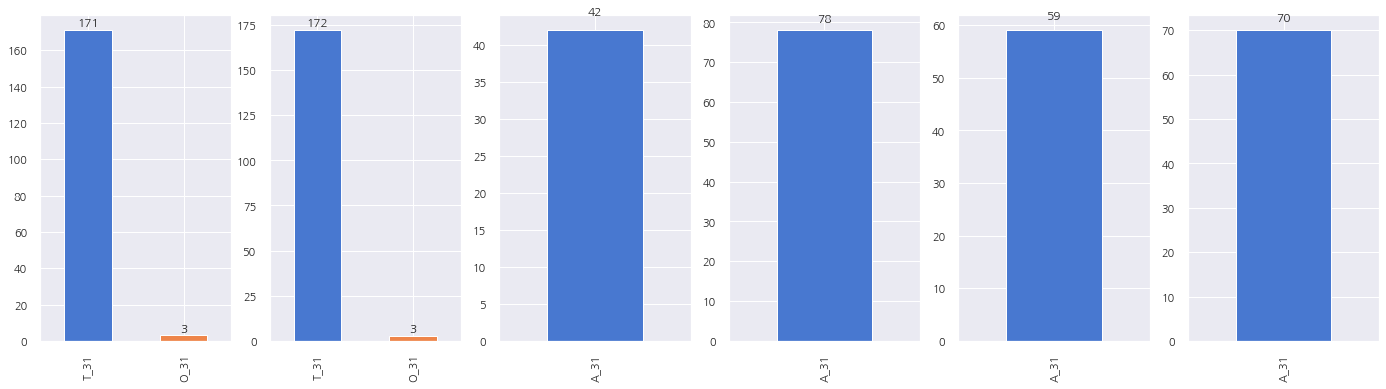

In [59]:
sns.set(font='NanumGothic', font_scale=1.0)
f, ax = plt.subplots(1, 6, figsize=(24,6))
bar_text(train_df[train_df['LINE'] == 'T100306']['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[0], color=colors), y=False)
bar_text(train_df[train_df['LINE'] == 'T100304']['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[1], color=colors), y=False)
bar_text(train_df[train_df['LINE'] == 'T050307']['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[2], color=colors), y=False)
bar_text(train_df[train_df['LINE'] == 'T050304']['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[3], color=colors), y=False)
bar_text(train_df[train_df['LINE'] == 'T010305']['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[4], color=colors), y=False)
bar_text(train_df[train_df['LINE'] == 'T010306']['PRODUCT_CODE'].value_counts().plot.bar(ax=ax[5], color=colors), y=False)

In [95]:
train_df = pd.read_csv("dataset/train.csv")
for col in train_df:
    if train_df[col].nunique() < 2:
        train_df.drop(columns=col, inplace=True)

In [96]:
corr = train_df.corr()[['Y_Quality']]
dup_idx = corr.duplicated(["Y_Quality"])
dup_list = list(corr[dup_idx].index)
for col in dup_list:
    train_df.drop(columns=col, inplace=True)

### T_31에 대해서 분석

In [98]:
T_31 = train_df[train_df["PRODUCT_CODE"] == "T_31"]
A_31 = train_df[train_df["PRODUCT_CODE"] == "A_31"]
O_31 = train_df[train_df["PRODUCT_CODE"] == "O_31"]
T_check = []
for prior in T_31:
    if T_31[prior].notnull().sum():
        T_check.append(prior)

A_check = []
for prior in A_31:
    if A_31[prior].notnull().sum():
        A_check.append(prior)

O_check = []
for prior in O_31:
    if O_31[prior].notnull().sum():
        O_check.append(prior)
print(len(A_check), len(O_check), len(T_check))

1174 445 455


In [99]:
T_31 = T_31[T_check]
A_31 = A_31[A_check]
O_31 = O_31[O_check]

In [104]:
def check_percentage(df, arr, percentage):
    for col in df:
        nan_count = df[col].isna().sum()
        total = df[col].count() + nan_count
        per = (nan_count / total) * 100
        if per >= percentage:
            arr.append(col)
nan_70 = []
check_percentage(T_31, nan_70, 70)
check_percentage(O_31, nan_70, 70)
check_percentage(A_31, nan_70, 70)

nan_60 = []
check_percentage(T_31, nan_60, 60)
check_percentage(O_31, nan_60, 60)
check_percentage(A_31, nan_60, 60)

nan_50 = []
check_percentage(T_31, nan_50, 50)
check_percentage(O_31, nan_50, 50)
check_percentage(A_31, nan_50, 50)

In [ ]:
import json
with open("parameter.json", 'r') as fp:
    data = json.load(fp)
data['nan_70'] = nan_70
data['nan_60'] = nan_60
data['nan_50'] = nan_50

with open("parameter.json", 'w') as fp:
    json.dump(data, fp, indent='\t')

In [29]:
train_df.drop(columns=arr, inplace=True)

In [34]:
corr = train_df.corr()
corr[['Y_Quality']].sort_values("Y_Quality")

,Y_Quality
X_120,-0.346879
X_121,-0.338000
X_90,-0.321369
X_1162,-0.265422
X_1667,-0.265422
...,...
X_1357,0.183098
X_1389,0.183961
X_73,0.341057
Y_Class,0.813885


In [136]:
import time
import json
prior = []
for c in train_df:
    if len(train_df[c].value_counts()) == 1:
        prior.append(c)


In [137]:

# save
parameter = dict()
parameter["all_same"] = prior  
parameter["all_nan"] = all_NAN
with open("parameter.json", 'w') as fp:
    json.dump(parameter, fp, indent='\t')


In [138]:
train_df = train_df.drop(columns=all_NAN)
train_df = train_df.drop(columns=prior)


In [141]:
train_df = train_df.drop(columns=['PRODUCT_ID', 'Y_Class', 'Y_Quality', 'TIMESTAMP', 'LINE', 'PRODUCT_CODE'])
train_df.head()

,X_1,X_2,X_5,X_7,X_8,X_9,X_11,X_12,X_13,X_15,...,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,197.286667,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,193.296552,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,179.820690,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,181.920690,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,196.393333,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97


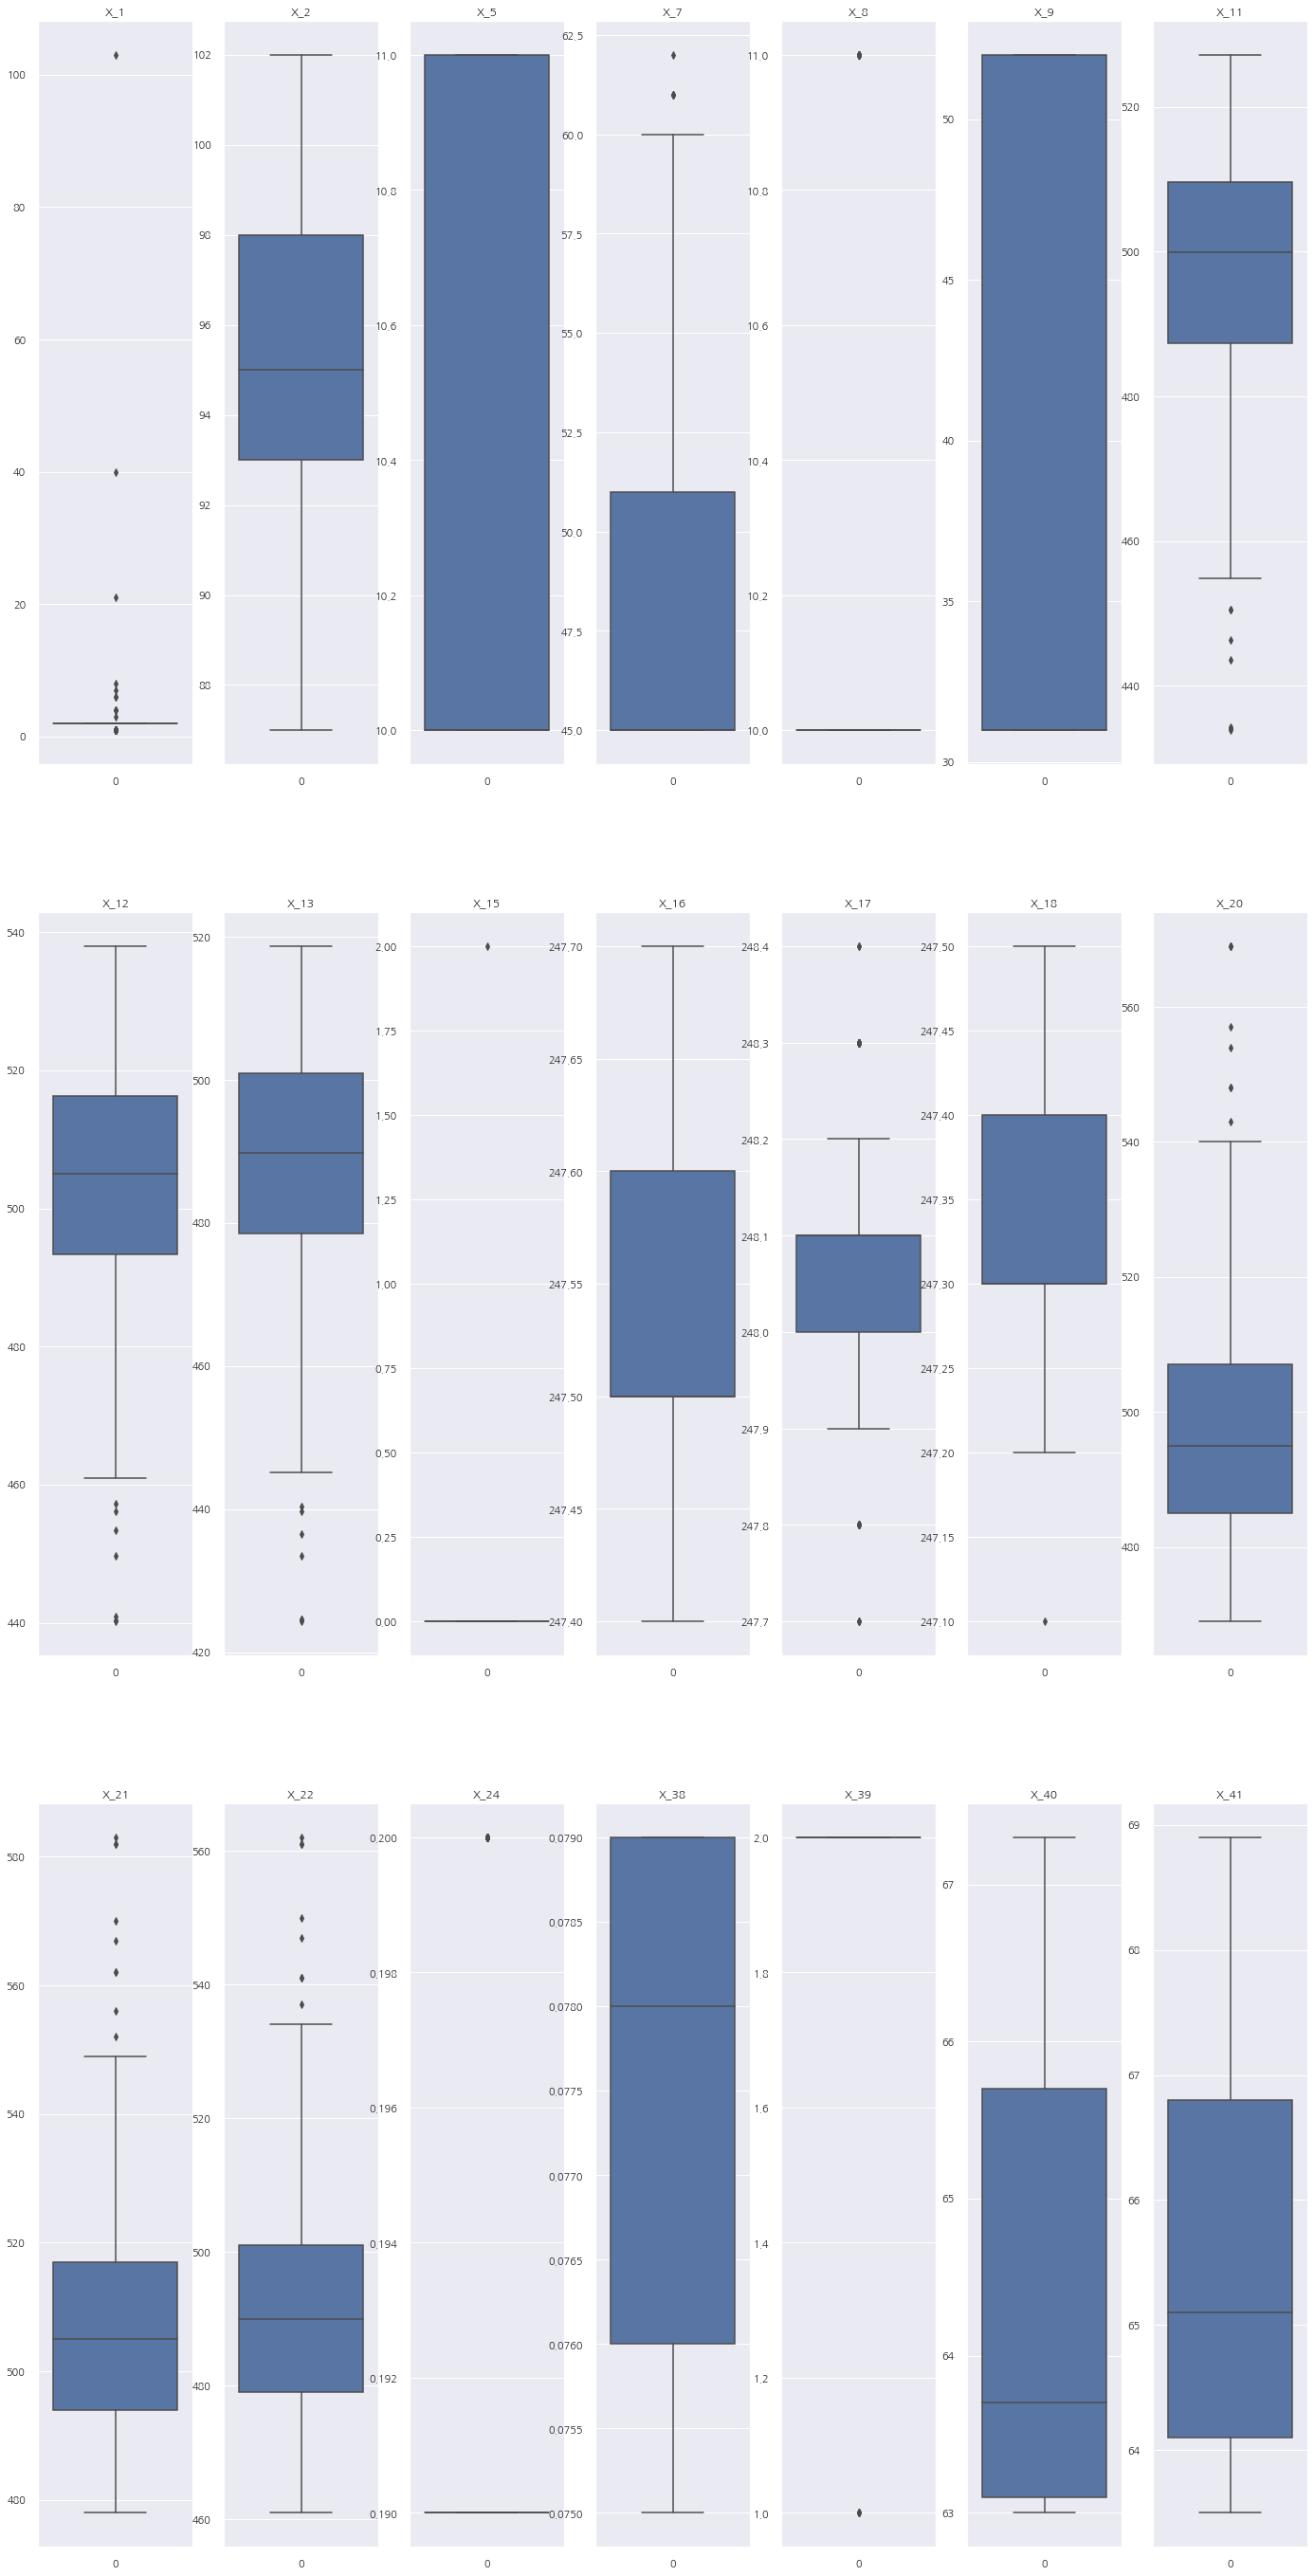

In [155]:
plt.figure(figsize=(24,49))
count = 1
num_features = train_df.select_dtypes(exclude=['object']).columns.to_list()

for i in range(3):
    for j in range(7):
        plt.subplot(3,7,count)
        p = sns.boxplot(data=train_df[num_features[i * 7 + j]])
        p.set_title(f'{num_features[i * 7 + j]}', fontsize=12)
        count+=1
plt.show()

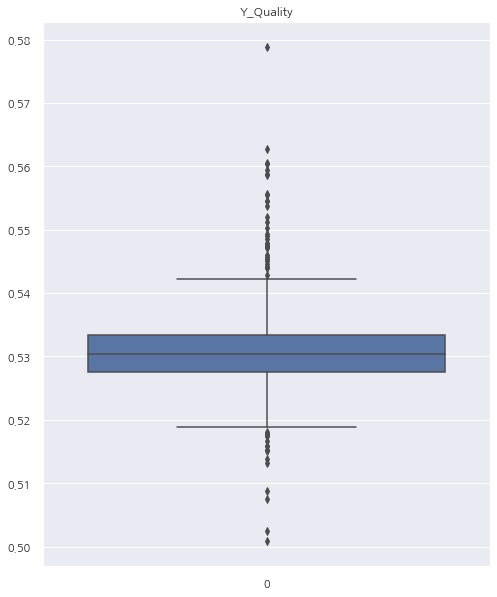

In [169]:
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

plt.figure(figsize=(8,10))
p = sns.boxplot(data=train_df["Y_Quality"])
p.set_title(f'Y_Quality', fontsize=12)
plt.show()

In [171]:
M = train_df["Y_Quality"].min()
Quality = train_df["Y_Quality"]

In [ ]:
correlation = pd.read_csv("correlation/correlation.csv")
dup = correlation.duplicated("Y_Quality")
list(correlation[dup]['Column'])

In [19]:
level_1 = correlation['Y_Quality'].quantile(0.1)
level_2 = correlation['Y_Quality'].quantile(0.9)

In [20]:
idx_1 = (correlation['Y_Quality'] < level_1) | (correlation['Y_Quality'] > level_2)
#sns.boxplot(data = correlation[idx_1])
#correlation[idx_1]
correlation['Column'][idx_1]


0           X_368
1           X_367
2           X_335
3          X_2779
4          X_1849
          ...    
2412       X_1525
2413       X_1524
2414       X_1523
2415       X_1407
2416    Y_Quality
Name: Unnamed: 0, Length: 1201, dtype: object

### Wasserstein distance for making values

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance as wd
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict


In [30]:
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

In [31]:
for col in train_df:
    if train_df[col].nunique() < 2:
        train_df.drop(columns=[col], inplace=True)
target = train_df.pop("Y_Quality")
train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'LINE', 'PRODUCT_CODE'], inplace=True)

In [32]:
nan_fill = defaultdict(float)
for c in train_df:
    m = train_df[c].median()
    train_df.fillna({c: m}, inplace=True)
    nan_fill[c] = m

In [ ]:
num_features = train_df.select_dtypes(exclude=['object']).columns.to_list()

In [34]:
#Scaling
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
train_df[num_features] = scaler.fit_transform(train_df[num_features])

NameError: name 'num_features' is not defined

In [17]:
idx0 = train_df.Y_Class == 0
idx1 = train_df.Y_Class == 1
idx2 = train_df.Y_Class == 2


In [24]:
cols_0_1 = {}
for col in train_df :
    target0 = train_df.loc[idx0 , [col]].dropna()
    target1 = train_df.loc[idx1 , [col]].dropna()
    
    m = MinMaxScaler(feature_range=(0,1))
    target0 = m.fit_transform(target0)
    target1 = m.fit_transform(target1)
    dist = wd(np.squeeze(target0) , np.squeeze(target1))
    #dist = wd(np.squeeze(target2) , np.squeeze(target3))
    #dist = wd(np.squeeze(target1) , np.squeeze(target3))
    cols_0_1[col] = dist


In [25]:
cols_1_2 = {}
for col in train_df :
    target1 = train_df.loc[idx1 , [col]].dropna()
    target2 = train_df.loc[idx2 , [col]].dropna()
    
    m = MinMaxScaler(feature_range=(0,1))
    target1 = m.fit_transform(target1)
    target2 = m.fit_transform(target2)
    dist = wd(np.squeeze(target1) , np.squeeze(target2))
    #dist = wd(np.squeeze(target2) , np.squeeze(target3))
    #dist = wd(np.squeeze(target1) , np.squeeze(target3))
    cols_1_2[col] = dist


In [26]:
tmp_0_1 = sorted(cols_0_1.items(), key=lambda x : x[1], reverse=True)
tmp_1_2 = sorted(cols_1_2.items(), key=lambda x : x[1], reverse=True)

In [27]:
class_0_1 = tmp_0_1[:20]
class_1_2 = tmp_1_2[:20]

In [28]:
class_0_1

[('X_280', 0.9975429975429976),
 ('X_666', 0.9975429975429976),
 ('X_276', 0.995085995085995),
 ('X_2433', 0.995085995085995),
 ('X_990', 0.9926289926289926),
 ('X_39', 0.9901719901719902),
 ('X_360', 0.9886363636363636),
 ('X_1785', 0.9886363636363636),
 ('X_95', 0.9803439803439837),
 ('X_1523', 0.9772727272727273),
 ('X_1524', 0.9772727272727273),
 ('X_1525', 0.9772727272727273),
 ('X_1975', 0.9742583492583492),
 ('X_1999', 0.9742583492583492),
 ('X_2011', 0.9742583492583492),
 ('X_904', 0.9680589680589681),
 ('X_2187', 0.9659090909090909),
 ('X_2547', 0.9659090909090909),
 ('X_2162', 0.9634520884520885),
 ('X_2163', 0.9634520884520885)]

In [ ]:
fig, axes = plt.subplots( 1,1, figsize=(10,20))
pos = np.arange(len(dist))
bars = plt.barh( pos , np.squeeze(dist))
plt.yticks(pos , name)
threshold = 0.4
importance_var = []
for idx , tick in enumerate( axes.yaxis.get_major_ticks()) :
    tick.label.set_fontsize(25)
    tick.label.set_rotation(25)
    if tick.label.get_text() in ["C" , "D"] :
        tick.label.set_color("green")
    if np.squeeze(dist)[idx] > threshold :
        tick.label.set_color("red")
        importance_var.append(name[idx])
        bars[idx].set_facecolor("red")
plt.vlines(x=threshold , ymin =-1 , ymax= len(dist))
plt.show()
print("중요 변수 : ",importance_var)

/home/dircon/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/dircon/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/dircon/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/dircon/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dircon/anaconda3/lib/python3.9/site-packages/seaborn/dis

<AxesSubplot:ylabel='Density'>

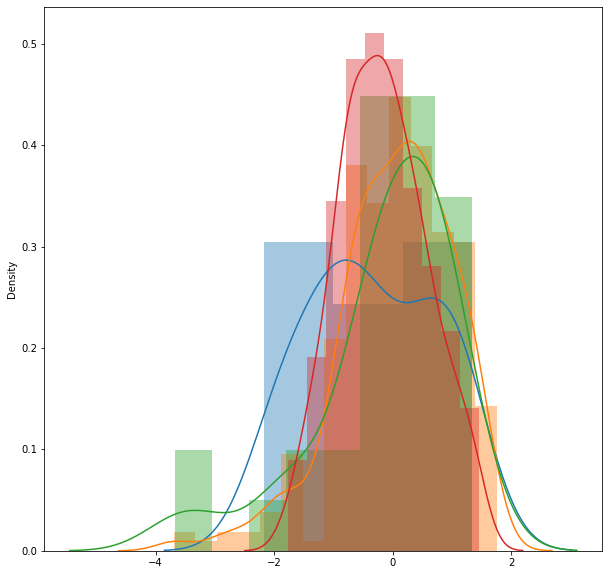

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns

train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

cat_features = ['LINE', 'PRODUCT_CODE', "TIMESTAMP", "PRODUCT_ID"]
num_features = [i for i in test.columns if i not in cat_features]
scaler = StandardScaler()
train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])


fig , axes = plt.subplots(nrows=1 ,ncols=1, figsize=(10,10) )
plt.subplots_adjust(left=None, bottom=None, right=None, 
                    top=None, wspace=None, hspace=0.5)

idx0 = train.Y_Class == 0
idx1 = train.Y_Class == 1
idx2 = train.Y_Class == 2
col = "X_13"

target_0 = train.loc[idx0, [col]]
target_1 = train.loc[idx1, [col]]
target_2 = train.loc[idx2, [col]]
test = test.loc[:, [col]]

sns.distplot(target_0, ax=axes)
sns.distplot(target_1, ax=axes)
sns.distplot(target_2, ax=axes)
sns.distplot(test, ax=axes)

In [39]:
cor = pd.read_csv("correlation/correlation_spearman.csv")['feature'].to_list()
for col in train:
    count = (~train[col].isna()).sum()
    if count < 50 and col in cor:
        print(col)
        

X_130
X_699
X_1407
X_1523
X_1708
X_1710
X_1969
X_1970
X_1971
X_1972
X_1973
X_1974
X_1975
X_1976
X_1977
X_1978
X_1979
X_1980
X_1981
X_1982
X_1983
X_1984
X_1985
X_1986
X_1987
X_1988
X_1989
X_1990
X_1991
X_1992
X_2029
X_2030
X_2031
X_2032
X_2033
X_2034
X_2037
X_2038
X_2039
X_2069
X_2085
X_2540
X_2541
X_2542
X_2545
X_2548
X_2551
X_2721
X_2722
X_2723
X_2773
X_2774
